## Least Square demo

- See <http://www.efunda.com/math/leastsquares/leastsquares.cfm>
- See <http://www.lediouris.net/original/sailing/PolarCO2/index.html>

In [1]:
%classpath add jar "../build/libs/Algebra-1.0-all.jar"

In [2]:
import smoothing.LeastSquaresMethod;
import matrix.SquareMatrix;
import matrix.SystemUtil;

import gsg.SwingUtils.WhiteBoardPanel;
import gsg.VectorUtils;

import java.util.concurrent.atomic.AtomicInteger;
import java.awt.Color;
import java.awt.Dimension;
import java.awt.Font;

### Data, and resolution

In [3]:
final int REQUIRED_SMOOTHING_DEGREE = 3;

if (true) { // Turn to true to re-generate data
    BufferedWriter bw = new BufferedWriter(new FileWriter("cloud.csv"));
    LeastSquaresMethod.cloudGenerator(bw, -8, 8, 0.01, new double[] {3, 4, 5, 6, 9}, 0.01, -0.04, 0.2, 1);
    bw.close();
}

if (true) {
    LeastSquaresMethod.csvToJson("cloud.csv", "cloud.json");
}

List<LeastSquaresMethod.Tuple> data = new ArrayList<>();
BufferedReader br = new BufferedReader(new FileReader("cloud.csv"));
String line = "";
boolean go = true;
while (go) {
    line = br.readLine();
    if (line == null) {
        go = false;
    } else {
        String[] tuple = line.split(";");
        data.add(new LeastSquaresMethod.Tuple(Double.parseDouble(tuple[0]), Double.parseDouble(tuple[1])));
    }
}
br.close();

// Data is a list of Tuples
int dimension = REQUIRED_SMOOTHING_DEGREE + 1;
double[] sumXArray = new double[(REQUIRED_SMOOTHING_DEGREE * 2) + 1]; // Will fill the matrix
double[] sumY      = new double[REQUIRED_SMOOTHING_DEGREE + 1];
// Init
for (int i=0; i<((REQUIRED_SMOOTHING_DEGREE * 2) + 1); i++) {
    sumXArray[i] = 0.0;
}
for (int i=0; i<(REQUIRED_SMOOTHING_DEGREE + 1); i++) {
    sumY[i] = 0.0;
}

data.stream().forEach(tuple -> {
    for (int i=0; i<((REQUIRED_SMOOTHING_DEGREE * 2) + 1); i++) {
        sumXArray[i] += Math.pow(tuple.getX(), i);
    }
    for (int i=0; i<(REQUIRED_SMOOTHING_DEGREE + 1); i++) {
        sumY[i] += (tuple.getY() * Math.pow(tuple.getX(), i));
    }
});

SquareMatrix squareMatrix = new SquareMatrix(dimension);
for (int row=0; row<dimension; row++) {
    for (int col=0; col<dimension; col++) {
        int powerRnk = (REQUIRED_SMOOTHING_DEGREE - row) + (REQUIRED_SMOOTHING_DEGREE - col);
        System.out.println("[" + row + "," + col + ":" + (powerRnk) + "] = " + sumXArray[powerRnk]);
        squareMatrix.setElementAt(row, col, sumXArray[powerRnk]);
    }
}
double[] constants = new double[dimension];
for (int i=0; i<dimension; i++) {
    constants[i] = sumY[REQUIRED_SMOOTHING_DEGREE - i];
    System.out.println("[" + (REQUIRED_SMOOTHING_DEGREE - i) + "] = " + constants[i]);
}

System.out.println("Resolving:");
SystemUtil.printSystem(squareMatrix, constants);
System.out.println();

double[] result = SystemUtil.solveSystem(squareMatrix, constants);
String out = "[ ";
for (int i=0; i<result.length; i++) {
    out += String.format("%s%f", (i > 0 ? ", " : ""), result[i]);
}
out += " ]";
System.out.println(out);
// Nicer (Java 8 and after)
System.out.println();
AtomicInteger integer = new AtomicInteger(0);
Arrays.stream(result)
                .boxed()
                .map(coef -> new LeastSquaresMethod.IndexedCoeff(integer.incrementAndGet(), coef))
                .forEach(ic -> System.out.println(String.format("Deg %d -> %f", (dimension - ic.getIdx()), ic.getCoef())));


Y in [-16.272184, 13.800980]
[0,0:6] = 3.009055012562896E8
[0,1:5] = -3.2014213502407074E-10
[0,2:4] = 6574097.066664035
[0,3:3] = -6.59383658785373E-11
[1,0:5] = -3.2014213502407074E-10
[1,1:4] = 6574097.066664035
[1,2:3] = -6.59383658785373E-11
[1,3:2] = 170986.79999999996
[2,0:4] = 6574097.066664035
[2,1:3] = -6.59383658785373E-11
[2,2:2] = 170986.79999999996
[2,3:1] = -1.829647544582258E-13
[3,0:3] = -6.59383658785373E-11
[3,1:2] = 170986.79999999996
[3,2:1] = -1.829647544582258E-13
[3,3:0] = 8005.0
[3] = 4410922.083781092
[2] = -91021.12389916783
[1] = 102723.8751355399
[0] = 1353.6204419999985
Resolving:
(300905501.256290 x A) + (-0.000000 x B) + (6574097.066664 x C) + (-0.000000 x D) = 4410922.083781
(-0.000000 x A) + (6574097.066664 x B) + (-0.000000 x C) + (170986.800000 x D) = -91021.123899
(6574097.066664 x A) + (-0.000000 x B) + (170986.800000 x C) + (-0.000000 x D) = 102723.875136
(-0.000000 x A) + (170986.800000 x B) + (-0.000000 x C) + (8005.000000 x D) = 1353.620442

[ 

## Graphics

In [4]:
WhiteBoardPanel whiteBoard = new WhiteBoardPanel();
whiteBoard.setAxisColor(new Color(125, 0, 255, 255));
whiteBoard.setWithGrid(true);
whiteBoard.setBgColor(new Color(250, 250, 250, 255));
whiteBoard.setGraphicTitle("Least Squares");
whiteBoard.setDimension(new Dimension(300, 600));
whiteBoard.setTextColor(Color.RED);
whiteBoard.setTitleFont(new Font("Arial", Font.BOLD | Font.ITALIC, 32));
whiteBoard.setGraphicMargins(30);

In [5]:
List<VectorUtils.Vector2D> cloudVectors = new ArrayList<>();

In [6]:
System.out.println(String.format("We have %d points in the cloud.", data.size()));
data.forEach(tuple -> {
    cloudVectors.add(new VectorUtils.Vector2D(tuple.getX(), tuple.getY()));
});

We have 8005 points in the cloud.


In [7]:
WhiteBoardPanel.DataSerie pointSerie = new WhiteBoardPanel.DataSerie()
                            .data(cloudVectors)
                            .graphicType(WhiteBoardPanel.GraphicType.POINTS)
                            .color(Color.BLUE);
whiteBoard.addSerie(pointSerie);

One Unit: 15.000000
40 vertical ticks, 20 horizontal ticks.
tickIncrement: 1
Working Rectangle: x:30, y:119, w:240, h:451


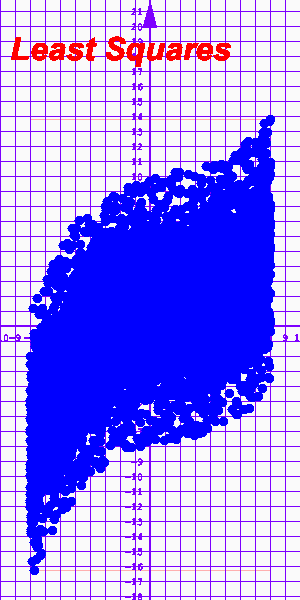

In [8]:
whiteBoard.getImage(); // This is for a Notebook

In [9]:
List<VectorUtils.Vector2D> function = new ArrayList<>();
for (double x=-10d; x<10d; x+=0.1) {
    function.add(new VectorUtils.Vector2D(x, LeastSquaresMethod.f(x, result)));
}

In [10]:
WhiteBoardPanel.DataSerie functionSerie = new WhiteBoardPanel.DataSerie()
                            .data(function)
                            .graphicType(WhiteBoardPanel.GraphicType.LINE)
                            .lineThickness(3)
                            .color(Color.GREEN);
whiteBoard.addSerie(functionSerie);

One Unit: 12.000000
50 vertical ticks, 25 horizontal ticks.
tickIncrement: 2
Working Rectangle: x:30, y:209, w:240, h:361


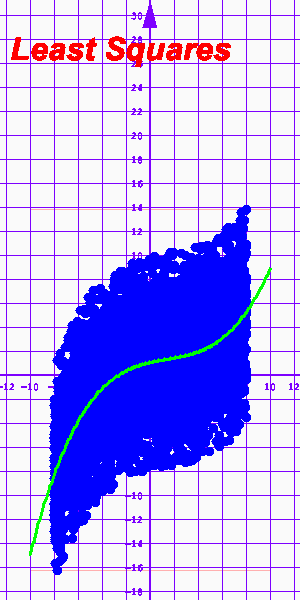

In [11]:
whiteBoard.getImage();

---